In [ ]:
import os
from scripts.utils import VirchowTileEmbeddingExtractor, PrismProcessor
import torch
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull, QhullError
import matplotlib.pyplot as plt
import sys
import importlib
import utils

from utils import TileExtractor

from utils import PrismProcessor
from caption_analysis import CaptionAnalyzer
import torch
import numpy as np
import pandas as pd


In [ ]:
scripts_path = '/content/drive/MyDrive/scripts'
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

importlib.reload(utils)

In [ ]:
from huggingface_hub import login

# login(token="")


**Initialize Extractors and Models**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
virchow_extractor = VirchowTileEmbeddingExtractor(device=device)
prism_processor = PrismProcessor(device=device)
text_encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)
# analyzer = PatientDataAnalyzer(device="cuda")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
BioGptForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/

In [ ]:
tile_sample_path = "outputs/embeddings-virchow/tile_virchow_1.pth"
tile_embeddings = prism_processor.load_tile_embeddings(tile_sample_path)

**Single Tile**

In [7]:
reprs = prism_processor.extract_slide_representations(tile_embeddings)
neg_prompts = ['lobular carcinoma, invasive']
pos_prompts = ['ductal carcinoma, invasive']
scores = prism_processor.zero_shot_classification(reprs['image_embedding'], neg_prompts, pos_prompts)
generated_caption = prism_processor.generate_caption(reprs['image_latents'])
caption = 'Breast tissue with signs of lobular carcinoma'
output = prism_processor.make_prediction(caption, tile_embeddings)

/usr/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Slide image embedding shape: torch.Size([1, 1280])
Slide image latents shape: torch.Size([1, 512, 1280])
Zero-shot classification scores: tensor([[0.0422, 0.9578]], device='cuda:0')
Generated caption: ['</s>Diagnosis: High-grade serous carcinoma of the ovary, fallopian tube, and peritoneum. </s>']
Model output keys: dict_keys(['logits', 'text_embedding', 'image_embedding', 'image_latents', 'sim'])


**Merge Tile**

In [9]:
patient_tiles_list = []
for i in range(1, 27):
    file_path = f"outputs/embeddings-output/image_{i}.pth"
    embedding_data = torch.load(file_path)
    tile_embeddings = embedding_data['embeddings'].to(device)  # shape: (seq_len, embed_dim)
    patient_tiles_list.append(tile_embeddings)

merged_tiles = torch.cat(patient_tiles_list, dim=0).unsqueeze(0)  # shape: (1, total_seq_len, embed_dim)
print("[INFO] Merged Patient Tile Embeddings Shape:", merged_tiles.shape)

reprs = prism_processor.extract_slide_representations_from_merged_tiles(merged_tiles)
print("[INFO] Slide Representations extracted.")

neg_prompts = ['lobular carcinoma, invasive']
pos_prompts = ['ductal carcinoma, invasive']
scores = prism_processor.zero_shot_classification_merged(reprs['image_embedding'], neg_prompts, pos_prompts)
print("[INFO] Zero-shot Classification Scores:", scores)

generated_caption = prism_processor.generate_caption_for_merged_tiles(reprs['image_latents'])
print("[INFO] Generated Caption:", generated_caption)

[INFO] Merged Patient Tile Embeddings Shape: torch.Size([1, 26, 2560])
[INFO] Slide Representations extracted.
[INFO] Zero-shot Classification Scores: tensor([[0.0040, 0.9960]], device='cuda:0')
[INFO] Generated Caption: </s>Diagnosis: Metastatic poorly differentiated carcinoma in lymph node. </s>


**Compute and plot the results for different temperature values**

In [6]:
tile_sample_path = "outputs/embeddings-virchow/tile_virchow_1.pth"
tile_embeddings = prism_processor.load_tile_embeddings(tile_sample_path)

Loaded embedding data keys: dict_keys(['embedding'])
Tile embeddings shape: torch.Size([1, 1, 2560])


**Extract slide representations**

In [8]:
latents = prism_processor.extract_slide_representations(tile_embeddings)['image_latents']
analyzer = CaptionAnalyzer(prism_model=prism_processor, device='cuda')
print("Slide Representations extracted.")

/usr/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Slide image embedding shape: torch.Size([1, 1280])
Slide image latents shape: torch.Size([1, 512, 1280])
Slide Representations extracted.


**Generate captions with temperature variations**

In [9]:
captions, temps = analyzer.generate_captions(latents)

Generated caption: ['</s>Diagnosis: High-grade serous carcinoma of the ovary, fallopian tube, and peritoneum. </s>']
Generated caption: ['</s>Diagnosis: High-grade serous carcinoma of the ovary, fallopian tube, and peritoneum. </s>']
Generated caption: ['</s>Diagnosis: High-grade serous carcinoma of the ovary, fallopian tube, and peritoneum. </s>']
Generated caption: ['</s>Diagnosis: High-grade serous carcinoma of the ovary, fallopian tube, and peritoneum. </s>']
Generated caption: ['</s>Diagnosis: High-grade serous carcinoma of the ovary, fallopian tube, and peritoneum. </s>']
Generated caption: ['</s>Diagnosis: High-grade serous carcinoma of the ovary, fallopian tube, and peritoneum. </s>']
Generated caption: ['</s>Diagnosis: High-grade serous carcinoma of the ovary, fallopian tube, and peritoneum. </s>']
Generated caption: ['</s>Diagnosis: High-grade serous carcinoma of the ovary, fallopian tube, and peritoneum. </s>']
Generated caption: ['</s>Diagnosis: High-grade serous carcinoma 

**Embed captions**

In [10]:
embeddings = analyzer.embed_captions(captions)

**Reduce to 2D using PCA**

In [11]:
pca = analyzer.reduce_embeddings_to_2d(embeddings)

**Cluster the 2D points**

In [12]:
labels, unique_labels = analyzer.cluster_embeddings(pca)

**Plot with convex hulls**

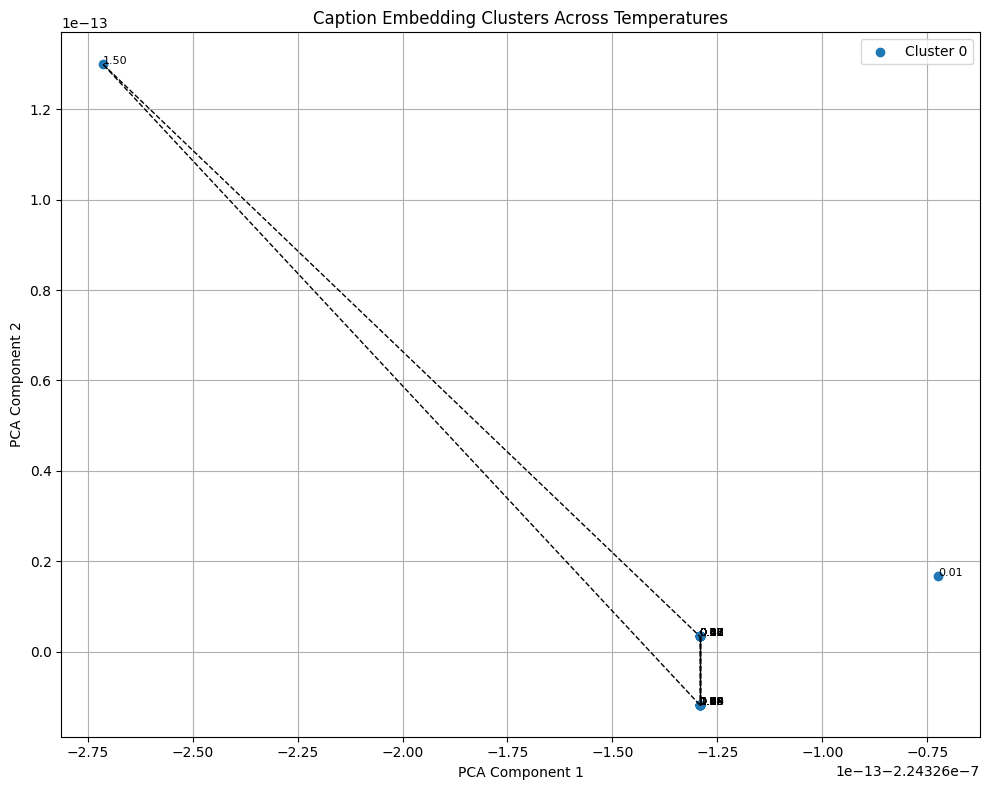

In [13]:
analyzer.plot_clusters_with_convex_hulls(pca, labels, unique_labels, temps)

**Saving Analysis to CSV**

In [14]:
embedding_folder = 'outputs/embeddings-virchow'
output_csv = 'outputs/patient_analysis.csv'

analyzer.analyze_patient_data_to_csv(embedding_folder, output_csv)


/usr/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Slide image embedding shape: torch.Size([1, 1280])
Slide image latents shape: torch.Size([1, 512, 1280])
Zero-shot classification scores: tensor([[0.0422, 0.9578]], device='cuda:0')
[SAVED] Analysis results to outputs/patient_analysis.csv


**Adding noise**

In [ ]:
embedding_path = 'outputs/embeddings-virchow/tile_virchow_1.pth'
embedding_data = torch.load(embedding_path)
embedding_tensor = embedding_data['embedding'].unsqueeze(0).to("cuda")

reprs = prism_processor.extract_slide_representations(embedding_tensor)

In [ ]:
preds, uncertainty, captions = analyzer.get_zero_shot_predictions_with_uncertainty(
    image_embedding=reprs['image_embedding'],
    image_latents=reprs['image_latents'],
    pos_prompts=["ductal carcinoma, invasive"],
    neg_prompts=["lobular carcinoma, invasive"],
    num_runs=20,  
    noise_std_emb=0.01,
    noise_std_latents=0.5
)

In [ ]:
print("Uncertainty (Variance):", uncertainty)
print("\nGenerated Captions:")
for i, cap in enumerate(captions):
    print(f"{i+1}: {cap}")


Slide image embedding shape: torch.Size([1, 1280])
Slide image latents shape: torch.Size([1, 512, 1280])
Zero-shot classification scores: tensor([[0.0408, 0.9592]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0412, 0.9588]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0440, 0.9560]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0418, 0.9582]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0432, 0.9568]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0448, 0.9552]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0432, 0.9568]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0407, 0.9593]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0435, 0.9565]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0416, 0.9584]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0429, 0.9571]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0434

Zero-shot classification scores: tensor([[0.0408, 0.9592]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0412, 0.9588]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0440, 0.9560]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0418, 0.9582]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0432, 0.9568]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0448, 0.9552]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0432, 0.9568]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0407, 0.9593]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0435, 0.9565]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0416, 0.9584]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0429, 0.9571]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0434, 0.9566]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0402, 0.9598]], device='cuda:0')

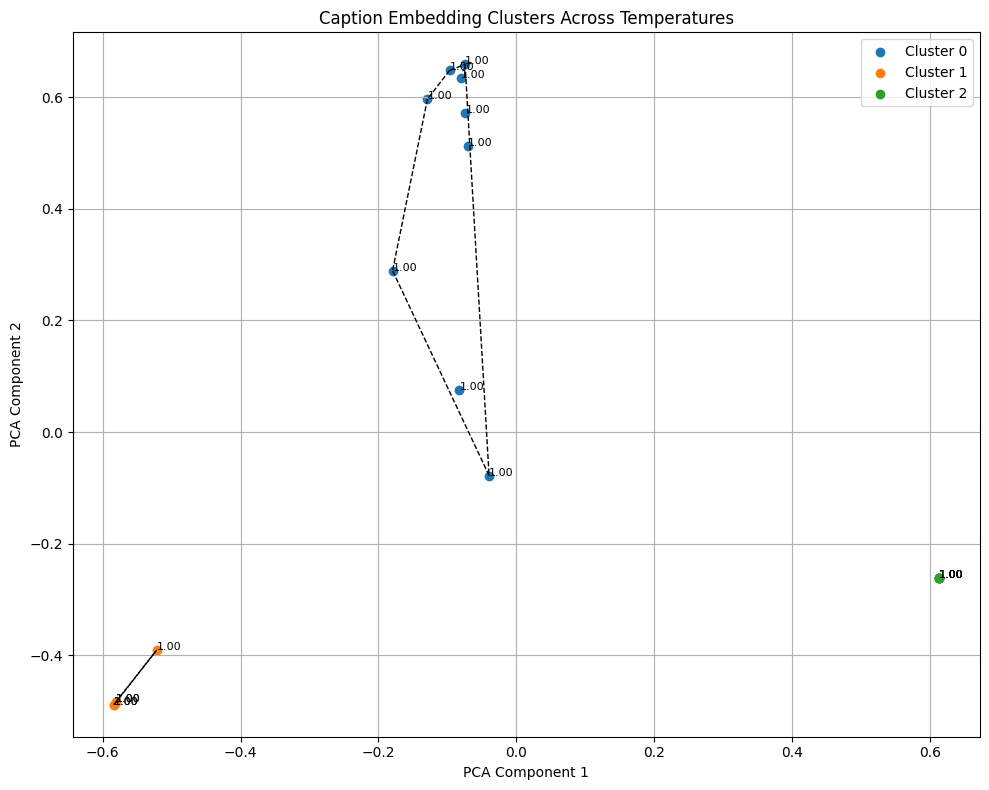

In [ ]:
analyzer.analyze_and_plot_for_temperature(
    image_embedding=reprs['image_embedding'],
    image_latents=reprs['image_latents'],
    pos_prompts=["ductal carcinoma, invasive"],
    neg_prompts=["lobular carcinoma, invasive"],
    num_runs=20,  
    fixed_temperature=1.0, 
    noise_std_emb=0.01,
    noise_std_latents=0.5
)


In [ ]:
analyzer.analyze_and_save_for_temperature(
    image_embedding=reprs['image_embedding'],
    image_latents=reprs['image_latents'],
    pos_prompts=["ductal carcinoma, invasive"],
    neg_prompts=["lobular carcinoma, invasive"],
    num_runs=20,  
    fixed_temperature=1.0,  
    noise_std_emb=0.01, 
    noise_std_latents=0.5,  
    output_csv='outputs/single_temp_noise_patient_analysis.csv' 
)


Zero-shot classification scores: tensor([[0.0408, 0.9592]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0412, 0.9588]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0440, 0.9560]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0418, 0.9582]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0432, 0.9568]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0448, 0.9552]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0432, 0.9568]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0407, 0.9593]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0435, 0.9565]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0416, 0.9584]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0429, 0.9571]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0434, 0.9566]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0402, 0.9598]], device='cuda:0')

,Identifier,Temperature,Generated Caption,Term Value,Uncertainty Value,Response
0,patient_image,1.0,Examined on the liver tissue reveal benign les...,0.959154,0.918309,Ductal
1,patient_image,1.0,Examined tissue; result: Necrosis of gastric m...,0.958847,0.917694,Ductal
2,patient_image,1.0,Examined tissue shows absence of tumor.,0.955981,0.911963,Ductal
3,patient_image,1.0,Examined tissue: Right lung biopsy showing nod...,0.958226,0.916452,Ductal
4,patient_image,1.0,Diagnosis: Superficial nodular basal cell carc...,0.956796,0.913592,Ductal
5,patient_image,1.0,Diagnosis: Breast tissue showing complex and a...,0.955152,0.910304,Ductal
6,patient_image,1.0,Examined tissue: Right supraclavicular lymph n...,0.956796,0.913592,Ductal
7,patient_image,1.0,"Diagnosis: Right lower lobe mass, high-grade d...",0.959307,0.918614,Ductal
8,patient_image,1.0,Diagnosis: No malignancy detected on breast ti...,0.956472,0.912944,Ductal
9,patient_image,1.0,Diagnosed with chronic inflammatory changes an...,0.958382,0.916764,Ductal


In [ ]:
temps = np.linspace(0.01, 1.5, 30)
all_results = []

for temp in temps:
    result_df = analyzer.analyze_and_save_for_temperature(
        image_embedding=reprs['image_embedding'],
        image_latents=reprs['image_latents'],
        pos_prompts=["ductal carcinoma, invasive"],
        neg_prompts=["lobular carcinoma, invasive"],
        num_runs=20,
        fixed_temperature=temp,
        noise_std_emb=0.01,
        noise_std_latents=0.5,
        output_csv=None 
    )

    result_df['Temperature'] = temp 
    all_results.append(result_df)


In [ ]:
final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv('outputs/noise_patient_analysis.csv', index=False)


Zero-shot classification scores: tensor([[0.0408, 0.9592]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0412, 0.9588]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0440, 0.9560]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0418, 0.9582]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0432, 0.9568]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0448, 0.9552]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0432, 0.9568]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0407, 0.9593]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0435, 0.9565]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0416, 0.9584]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0429, 0.9571]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0434, 0.9566]], device='cuda:0')
Zero-shot classification scores: tensor([[0.0402, 0.9598]], device='cuda:0')